In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from lxml import etree  
import glob 
from collections import Counter
import cv2


In [2]:
words_meta_filename = "../../data/ascii/words.txt"
forms_meta_filename = "../../data/ascii/forms.txt"
xml_files_path = "../../data/xml"

#FORMS_IMG_PATH = '../data/forms'
WORDS_IMG_PATH = '../../data/words'

word_columns = ['word_id', 'seg_res', 'gray_level', 'x', 'y', 'w', 'h', 'tag', 'transcription']
forms_columns = ['form_id', 'writer_id', 'number_of_sentences', 'word_seg', 'total_lines', 'correct_lines', 'total_words', 'correct_words']


In [3]:
def parse_my_form_file(filename):
    with open(filename) as f:
        for line in f:
            if line.startswith('#'):
                continue
            yield line.strip().split(' ')

def parse_my_word_file(filename):
    with open(filename) as f:
        for line in f:
            if line.startswith('#'):
                continue
            yield line.strip().split(' ',len(word_columns) - 1)

def get_form_img_path_by_form_id(form_id):
    first_letter = form_id[0]
    if first_letter in ['a', 'b', 'c', 'd']:
        base_path = "../data/formsA-D/" 
    elif first_letter in ['e', 'f', 'g', 'h']:
        base_path = "../data/formsE-H/" 
    else:
        base_path = "../data/formsI-Z/" 
    return base_path + form_id +'.png'

def get_word_image_path_by_word_id(word_id):
    path_parts = word_id.split('-')
    return WORDS_IMG_PATH + '/' + path_parts[0] + '/' + "-".join(path_parts[0:2]) + '/' + word_id+ '.png'

def get_form_img_path_by_word_id(word_id):
    path_parts = word_id.split('-')
    first_letter = path_parts[0][0].lower()
    if first_letter in ['a', 'b', 'c', 'd']:
        base_path = "../data/formsA-D/" 
    elif first_letter in ['e', 'f', 'g', 'h']:
        base_path = "../data/formsE-H/" 
    else:
        base_path = "../data/formsI-Z/" 
    return base_path + "-".join(path_parts[0:2]) + '.png'

def get_img_mean(id):
    image = plt.imread(get_word_image_path_by_word_id(id))
    return image.mean()

def get_michelson_contrast(img_path):
    """
        Retourne le contraste de Michelson pour un chemin d'image donné
        Les valeurs possibles sont comprises entre 0 et 1 et vaut -1 en cas d'erreur
    """
    try:
        img = cv2.imread(img_path)
        Y = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)[:,:,0]
    except Exception:
        return -1
    min = int(np.min(Y))
    max = int(np.max(Y))
    if min == 0 and max == 0:
        return 0 
    return ((max - min) / (min + max))

In [5]:
form_df = pd.DataFrame(parse_my_form_file(forms_meta_filename), columns=forms_columns)
form_df.describe()
form_df.to_pickle('../../pickle/preprocessing_form_df_before.pickle')

In [7]:
form_df = pd.DataFrame(parse_my_form_file(forms_meta_filename), columns=forms_columns)
form_df[['total_lines', 'correct_lines', 'total_words', 'correct_words']] = form_df[['total_lines', 'correct_lines', 'total_words', 'correct_words']].astype(int)
form_df['text_id'] = form_df.form_id.apply(lambda x: x[:3])
form_df = form_df[['form_id', 'writer_id', 'text_id', 'number_of_sentences', 'word_seg',
       'total_lines', 'correct_lines', 'total_words', 'correct_words']]
form_df['form_img_path'] = form_df['form_id'].apply(lambda x: get_form_img_path_by_form_id(x))
form_df.to_pickle('../../pickle/preprocessing_form_df_after.pickle')

In [5]:
df = pd.DataFrame(parse_my_word_file(words_meta_filename), columns=word_columns)
df.describe()
df.to_pickle('../../pickle/preprocessing_word_df_before.pickle')

In [7]:
df['word_img_path'] = df['word_id'].apply(lambda x: get_word_image_path_by_word_id(x))
df['michelson_contrast'] = df['word_img_path'].apply(lambda x: get_michelson_contrast(x))
df.to_pickle('../../pickle/preprocessing_word_df_bad_contrast.pickle')

In [9]:
df = pd.DataFrame(parse_my_word_file(words_meta_filename), columns=word_columns)
df['x'] = df['x'].astype(int)
df['y'] = df['y'].astype(int)
df['w'] = df['w'].astype(int)
df['h'] = df['h'].astype(int)
df['gray_level'] = df['gray_level'].astype(int)
df['word_img_path'] = df['word_id'].apply(lambda x: get_word_image_path_by_word_id(x))
df['form_img_path'] = df['word_id'].apply(lambda x: get_form_img_path_by_word_id(x))
corrupted_word_imgs=[4152, 113621]

df = df.drop(index = corrupted_word_imgs).reset_index()
df = df[df['seg_res'] != 'err']
df.drop('seg_res', axis=1, inplace=True)
df['michelson_contrast'] = df['word_img_path'].apply(lambda x: get_michelson_contrast(x))
df = df[df['michelson_contrast'] > 0]
df['gray_level_mot'] = df.word_id.apply(get_img_mean)
df['form_id'] = df.word_id.apply(lambda x: '-'.join(x.split(sep='-')[:2]))
df = pd.merge(left=df, right=form_df, on='form_id', how='left')

In [ ]:
df.head()

,index,word_id,gray_level,x,y,w,h,tag,transcription,word_img_path,...,form_id,writer_id,text_id,number_of_sentences,word_seg,total_lines,correct_lines,total_words,correct_words,form_img_path_y
0,0,a01-000u-00-00,154,408,768,27,51,AT,A,../data/words/a01/a01-000u/a01-000u-00-00.png,...,a01-000u,000,a01,2,prt,7,5,52,36,../data/formsA-D/a01-000u.png
1,1,a01-000u-00-01,154,507,766,213,48,NN,MOVE,../data/words/a01/a01-000u/a01-000u-00-01.png,...,a01-000u,000,a01,2,prt,7,5,52,36,../data/formsA-D/a01-000u.png
2,2,a01-000u-00-02,154,796,764,70,50,TO,to,../data/words/a01/a01-000u/a01-000u-00-02.png,...,a01-000u,000,a01,2,prt,7,5,52,36,../data/formsA-D/a01-000u.png
3,3,a01-000u-00-03,154,919,757,166,78,VB,stop,../data/words/a01/a01-000u/a01-000u-00-03.png,...,a01-000u,000,a01,2,prt,7,5,52,36,../data/formsA-D/a01-000u.png
4,4,a01-000u-00-04,154,1185,754,126,61,NPT,Mr.,../data/words/a01/a01-000u/a01-000u-00-04.png,...,a01-000u,000,a01,2,prt,7,5,52,36,../data/formsA-D/a01-000u.png


In [ ]:
print(len(df))
form_df.to_pickle('../../pickle/preprocessing_word_df_after.pickle')

96420


In [8]:
import pickle

df.to_pickle('../pickle/df.pickle')

## Détection des contours

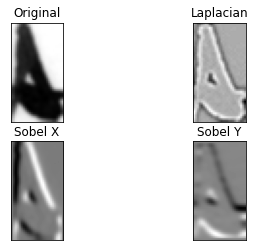

In [9]:
import cv2
import numpy as np
from matplotlib import pyplot as plt



img_arr = cv2.imread(df.iloc[0].word_img_path)
gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
img = cv2.GaussianBlur(gray,(3,3),0)

laplacian = cv2.Laplacian(img,cv2.CV_64F)
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0, ksize=5)  
sobely = cv2.Sobel(img,cv2.CV_64F,0,1, ksize=5)  


plt.subplot(2,2,1),
plt.imshow(img,cmap = 'gray')
plt.title('Original')
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,2),
plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian')
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,3)
plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X')
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,4)
plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y')
plt.xticks([])
plt.yticks([])

plt.show()

../data/words/a01/a01-030/a01-030-00-08.png


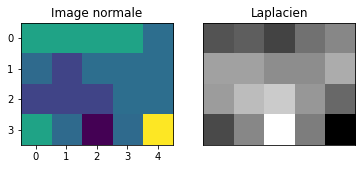

In [10]:
def get_laplacian_img_for_row(row):
    img_arr = cv2.imread(row.word_img_path)
    gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(gray,(3,3),0)
    return cv2.Laplacian(img,cv2.CV_64F)



bad_contrast_row = df[df['michelson_contrast'] <= 0.2].iloc[0]
laplacian_bad_constrast = get_laplacian_img_for_row(bad_contrast_row)
print(bad_contrast_row.word_img_path)

plt.subplot(1,2,1),
plt.title('Image normale')
plt.imshow(plt.imread(bad_contrast_row.word_img_path));
plt.subplot(1,2,2),
plt.imshow(laplacian_bad_constrast,cmap = 'gray');
plt.title('Laplacien')
plt.xticks([])
plt.yticks([])
plt.show()
